# Stuff

In [3]:
import random

import pandas as pd
import numpy as np
from pathlib import Path

from bioblp.data import COL_EDGE, COL_SOURCE, COL_TARGET
from bioblp.logging import get_logger
import torch


logger = get_logger(__name__)


In [2]:
np.logspace(-4, 3, 8)

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [2]:
DATA_DIR = Path("../data/")
DATA_SHARED = Path("/home/jovyan/workbench-shared-folder/bioblp")

In [3]:
dpi_benchmark_path = DATA_SHARED.joinpath('data/benchmarks/benchmarks/dpi_fda.tsv')

In [4]:
dpi_bm = pd.read_csv(dpi_benchmark_path, sep='\t', names=[COL_SOURCE, COL_EDGE, COL_TARGET])
dpi_bm.head(3)

,src,edg,tgt
0,DB01079,DPI,Q13639
1,DB00114,DPI,P20711
2,DB01158,DPI,P13637


In [5]:
len(dpi_bm)

19161

In [6]:
from typing import List

ent2id_map = pd.read_csv(DATA_SHARED.joinpath("models/1baon0eg/training_triples/entity_to_id.tsv.gz"), sep="\t", compression="gzip")
ent2id_map = {v[1]: v[0] for v in ent2id_map.values}

def get_ent_ids_for_entity_list(entity_list: List[str], ent2id_map):
    ids = [ent2id_map.get(ent) for ent in entity_list]
    return ids

In [7]:

model_dir = DATA_SHARED.joinpath('models/1baon0eg')
print(f'Loading trained model from {model_dir}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load(model_dir.joinpath(f"trained_model.pkl"), map_location=device)
#if not torch.cuda.is_available():
#    model.device = 'cpu'

Loading trained model from /home/jovyan/workbench-shared-folder/bioblp/models/1baon0eg


In [8]:
entity_representation = model.entity_representations[0]._embeddings
relation_representation = model.relation_representations[0]._embeddings
entity_representation

Embedding(106339, 512)

In [9]:
dpi_bm_drugs = list(dpi_bm.src.values)
drug_ids = get_ent_ids_for_entity_list(dpi_bm_drugs, ent2id_map)

drug_ids = torch.LongTensor(drug_ids)
#drug_embs = model.entity_representations[0](drug_ids)
drug_embs = model.entity_representations[0]._embeddings(drug_ids)

In [10]:
dpi_bm_prots = list(dpi_bm.tgt.values)
prot_ids = get_ent_ids_for_entity_list(dpi_bm_prots, ent2id_map)   
prot_ids = torch.LongTensor(prot_ids)
prot_embs = model.entity_representations[0]._embeddings(prot_ids)

In [11]:
drug_embs.shape, prot_embs.shape


(torch.Size([19161, 512]), torch.Size([19161, 512]))

In [12]:
from collections.abc import Callable

def concatenate(emb1, emb2):
    out = torch.cat((emb1, emb2), dim=1)
    return out

def average(emb1, emb2):
    concat = torch.cat((emb1, emb2), dim=0).view(2, -1)
    out = torch.stack((emb1, emb2)).mean(dim=0).view(1,-1)
    return out

def encode_entity_pair(emb1, emb2, transform:Callable):
    return transform(emb1, emb2)


In [13]:
X = encode_entity_pair(emb1=drug_embs, emb2=prot_embs, transform=concatenate)


In [14]:
X.shape

torch.Size([19161, 1024])

In [15]:
Y = torch.ones((X.shape[0],))

In [17]:
#
# Negatives
#
seed_torch = 2022

unique_drug_ids = drug_ids.unique()
unique_prot_ids = prot_ids.unique()

drug_sample_ids = torch.tensor(random.choices(range(unique_drug_ids.shape[0]), k=X.shape[0]))
drugs_sampled = unique_drug_ids[drug_sample_ids]
drugs_sampled_embs = model.entity_representations[0]._embeddings(drugs_sampled)

prot_sample_ids = torch.tensor(random.choices(range(unique_prot_ids.shape[0]), k=X.shape[0]))
prots_sampled = unique_prot_ids[prot_sample_ids]
prot_sampled_embs = model.entity_representations[0]._embeddings(prots_sampled)


X_neg = encode_entity_pair(emb1=drugs_sampled_embs, emb2=prot_sampled_embs, transform=concatenate)

y_neg = torch.zeros((X_neg.shape[0],))

In [18]:
X_train = torch.cat((X, X_neg), dim=0).detach().numpy()
y_train = torch.cat((Y, y_neg), dim=0).numpy()

In [19]:
del model, 

In [20]:
import os
import numpy as np
import random as rn

from argparse import ArgumentParser
from pathlib import Path
from time import time
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score


from collections import defaultdict

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate


In [35]:
SEED = 2022

#
# DEFAULT PARAMETERS FOR RR
#
rf_default_params = {
    'n_estimators': 300,
    'criterion': 'gini',
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'auto',
    'random_state': SEED,
    'n_jobs': -1,

}

lr_default_params = {
    'C': 1.0,
    'random_state': SEED,
    'max_iter': 1000,
    'solver': 'lbfgs',
    'n_jobs': -1,
}


#
# OPT SPACES FOR RR
#

rf_search_space = {
    "criterion": ["gini", "entropy"],
    'n_estimators': np.arange(100, 300, 50, dtype=int),
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 5, 10, 15, 100],
    'max_depth': [5, 8, 15, 25, 30, None],
    'random_state': [SEED]
}

lr_search_space = {
    'penalty': ['l2'],
    'C': np.logspace(-4, 3, 8),
    'random_state': [SEED],
    'max_iter': [1000],
    'solver': ['lbfgs'],
    'n_jobs': [-1],
}


In [36]:

def run_nested_cv(candidates: list, X, y, scoring: dict,
                  outer_n_folds: int = 5, inner_n_folds: int = 2, inner_n_iter: int = 10, shuffle: bool = False,
                  random_state: int = SEED, n_jobs: int = 12, refit_param: str = 'fbeta', verbose: int = 0) -> dict:
    """Nested cross validation routine.
    Inner cv loop performs hp optimization on all folds and surfaces
    Parameters
    ----------
    candidates : list
        list of (label, estimator, param_dist)
    X : np.array
        predictor
    y : np.ndarray
        labels
    scoring : dict
        dict containing sklearn scorers
    outer_n_folds : int, optional
        splits for outer cv, by default 5
    inner_n_folds : int, optional
        splits for inner cv, by default 2
    inner_n_iter : int, optional
        number of trials within inner fold, by default 10
    shuffle : bool, optional
        shuffles data before cv, by default True
    random_state : int, optional
        seed for rng, by default SEED
    n_jobs : int, optional
        multiprocessing, by default 10
    refit_param : str, optional
        which metric to optimize for and return refit model, by default 'fbeta'
    verbose : int, optional
        level of console feedback, by default 0
    Returns
    -------
    dict
        outer cv scores e.g. {name: scores}
    """
    gridcvs = {}

    inner_cv = StratifiedKFold(n_splits=inner_n_folds, shuffle=shuffle, random_state=random_state)

    for name, estimator, param_grid in candidates:
        gcv = RandomizedSearchCV(
                estimator=estimator,
                param_distributions=param_grid,
                n_iter=inner_n_iter,
                scoring=scoring,
                n_jobs=1,
                cv=inner_cv,
                verbose=10,
                refit=refit_param,
                random_state=random_state)
        gridcvs[name] = gcv

    outer_cv = StratifiedKFold(n_splits=outer_n_folds, shuffle=shuffle, random_state=random_state)
    outer_scores = {}

    for name, gs_est in sorted(gridcvs.items()):
        logger.info(f"Running CV for {name}..")
        nested_score = cross_validate(gs_est,
                                      X=X,
                                      y=y,
                                      scoring=scoring,
                                      cv=outer_cv,
                                      n_jobs=n_jobs,
                                      return_estimator=False,
                                      return_train_score=True,
                                      verbose=10)

        score_to_optimize = nested_score.get('test_{}'.format(refit_param))
        logger.info(
            f'{name}: outer {refit_param} {100*score_to_optimize.mean():.2f} +/- {100*score_to_optimize.std():.2f}')
        outer_scores[name] = nested_score
    return outer_scores

In [39]:


# reproducibility
SEED = 2022


# def set_seeds(seed: int = SEED):
#     os.environ['PYTHONHASHSEED'] = str(SEED)
#     np.random.seed(SEED)
#     tf.random.set_seed(SEED)
#     rn.seed(SEED)



experiment_config = {
    "n_proc": 2,
    "n_iter": 2,
    "inner_n_folds": 3,
    "outer_n_folds": 5,
    "param": "fbeta"
}

# data_dir = experiment_base_path.joinpath(experiment_config["data_dir"])
# out_dir = experiment_base_path.joinpath(experiment_config["out_dir"])

# mkdir(out_dir)

n_proc = experiment_config["n_proc"]
n_iter = experiment_config["n_iter"]
inner_n_folds = experiment_config["inner_n_folds"]
outer_n_folds = experiment_config["outer_n_folds"]
optimize_param = experiment_config["param"]

# set_seeds(seed=SEED)

shuffle = True

exp_output = defaultdict(dict)
exp_output['settings'] = {
    # 'data_dir': data_dir,
    'n_iter': n_iter,
    'inner_n_folds': inner_n_folds,
    'outer_n_folds': outer_n_folds,
    'optimize_param': optimize_param,
    'shuffle': shuffle,
    'seed': SEED
}

start = time()

logger.info("Starting model building script at {}.".format(start))

############
# Load data
############
logger.info("Loading training data...")

# X_train = np.load(data_dir.joinpath('X_train.npy'))
# y_train = np.load(data_dir.joinpath('y_train.npy'))

logger.info("Resulting shapes X_train: {}, y_train: {}".format(X_train.shape, y_train.shape))
logger.info("Counts in y_train: {}".format(np.unique(y_train, return_counts=True)))
############
# Setup classifiers & pipelines
############

lr_label = 'LR'
clf_lr = LogisticRegression(**lr_default_params)

rf_label = 'RF'
clf_rf = RandomForestClassifier(**rf_default_params)


# record default params
exp_output['default_params']: {
    lr_label: lr_default_params,
    rf_label: rf_default_params
}

############
# Setup grids
############
exp_output['grids']: {
    lr_label: lr_search_space,
    rf_label: rf_search_space
}

############
# Compare models
############
candidates = [
    (lr_label, clf_lr, lr_search_space),
    (rf_label, clf_rf, rf_search_space)
]

scorer = {
    'AUC': make_scorer(roc_auc_score),
    'fbeta': make_scorer(fbeta_score, beta=1, average='micro'),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score)
}

nested_cv_scores = run_nested_cv(
    candidates=candidates,
    X=X_train,
    y=y_train,
    scoring=scorer,
    inner_n_folds=inner_n_folds,
    inner_n_iter=n_iter,
    outer_n_folds=outer_n_folds,
    shuffle=shuffle,
    n_jobs=n_proc,
    refit_param=optimize_param,
    random_state=SEED
)

for algo, scores in nested_cv_scores.items():
    logger.info("Scores {}: {}".format(algo, scores))

exp_output['results'] = nested_cv_scores

logger.info(exp_output)

run_timestamp = int(time())
# file_out = out_dir.joinpath('nested_cv_scores_{}.npy'.format(run_timestamp))
# logger.info("Saving to {}".format(file_out))
# np.save(file_out, exp_output)

end = time()

logger.info("Ran script in {} seconds".format(str(end - start)))

2022-09-06 12:16:17,931 [INFO] __main__: Starting model building script at 1662466577.9317775.
2022-09-06 12:16:17,932 [INFO] __main__: Loading training data...
2022-09-06 12:16:17,933 [INFO] __main__: Resulting shapes X_train: (38322, 1024), y_train: (38322,)
2022-09-06 12:16:17,935 [INFO] __main__: Counts in y_train: (array([0., 1.], dtype=float32), array([19161, 19161]))
2022-09-06 12:16:17,936 [INFO] __main__: Running CV for LR..


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=2)]: Done   3 out of   5 | elapsed:   14.8s remaining:    9.9s


2022-09-06 12:16:36,867 [INFO] __main__: LR: outer fbeta 74.06 +/- 0.30
2022-09-06 12:16:36,868 [INFO] __main__: Running CV for RF..


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   18.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   18.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:  1.9min remaining:    0.0s

KeyboardInterrupt



_____

In [1]:
import random

import pandas as pd
import numpy as np
from pathlib import Path

from bioblp.data import COL_EDGE, COL_SOURCE, COL_TARGET
from bioblp.logging import get_logger
import torch





from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

from sklearn.model_selection import cross_validate


/home/jovyan/.conda/envs/bioblp-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logger = get_logger(__name__)


In [3]:
DATA_DIR = Path("../data/")
DATA_SHARED = Path("/home/jovyan/workbench-shared-folder/bioblp")

In [4]:
def aupr_score(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    # Use AUC function to calculate the area under the curve of precision recall curve
    return auc(recall, precision)


In [5]:
scorer = {
    "AUCROC": make_scorer(roc_auc_score, needs_proba=True),
    "f1": make_scorer(fbeta_score, beta=1, average="micro"),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "accuracy": make_scorer(accuracy_score),
    "AUCPR": make_scorer(aupr_score, needs_proba=True),
}

In [6]:
logger.info("Loading training data...")

X_train = np.load(DATA_DIR.joinpath("features/dpi_X.npy"))
y_train = np.load(DATA_DIR.joinpath("features/dpi_y.npy"))

logger.info(
        "Resulting shapes X_train: {}, y_train: {}".format(X_train.shape, y_train.shape)
    )
logger.info("Counts in y_train: {}".format(np.unique(y_train, return_counts=True)))

16:17:35 - INFO - __main__ - Loading training data...
16:17:35 - INFO - __main__ - Resulting shapes X_train: (38322, 1024), y_train: (38322,)
16:17:35 - INFO - __main__ - Counts in y_train: (array([0, 1]), array([19161, 19161]))


In [7]:
import optuna


In [8]:



# def lr_objective(trial):
#     random_state = 42
#     n_jobs = -1
#     solver="lbfgs"
#     C = trial.suggest_float("C", 1e-5, 1e3, log=True)
#     refit_param="AUCPR"

#     clf_obj = LogisticRegression(random_state=random_state,
#                                 n_jobs=n_jobs,
#                                 C=C,
#                                 solver=solver)

#     result = cross_validate(clf_obj, X=X_train, y=y_train,
#                             scoring=scorer, cv=5, n_jobs=n_jobs,
#                             return_estimator=False,
#                             return_train_score=True,
#                             verbose=14)
#     logger.info(result)
    
#     score_to_optimize = result.get("test_{}".format(refit_param)).mean()
    
#     return score_to_optimize

# # generate study name based on model, fold and some random word?
# study = optuna.create_study(direction='maximize', study_name="trial1")
# study.optimize(lr_objective, n_trials = 50)

# trial = study.best_trial

# print('Mean Score: {}'.format(trial.value))
# print("Best hyperparameters: {}".format(trial.params))

In [9]:
import random
import string

def get_random_string(length):
    # choose from all lowercase letter
    characters = string.ascii_lowercase + string.digits
    result_str = ''.join(random.choice(characters) for i in range(length))
    
    return result_str



In [10]:
def lr_callback(trial):
    
    random_state = 42
    n_jobs = -1
    solver="lbfgs"
    
    C = trial.suggest_float("C", 1e-5, 1e3, log=True)

    clf_obj = LogisticRegression(random_state=random_state,
                                 n_jobs=n_jobs,
                                 C=C,
                                 solver=solver)
    return clf_obj


def rf_callback(trial):
    """
        rf_search_space = {
        "criterion": ["gini", "entropy"],
        "n_estimators": np.arange(100, 300, 50, dtype=int),
        "min_samples_leaf": [1, 2, 5, 10],
        "min_samples_split": [2, 5, 10, 15, 100],
        "max_depth": [5, 8, 15, 25, 30, None],
        "random_state": [SEED],
    }
    """
    
    random_state = 42
    n_jobs = -1
    solver="lbfgs"
    
    criterion = trial.suggest_categorical("rf_criterion", ["gini", "entropy"])
    n_estimators = trial.suggest_int("rf_n_estimators", low=100, high=300, step=50)
    min_samples_leaf = trial.suggest_int("rf_min_samples_leaf", low=1, high=10, log=True)
    min_samples_split = trial.suggest_int("rf_min_samples_split", low=2, high=100, log=True)
    max_depth = trial.suggest_categorical("rf_max_depth", [5, 8, 15, 25, 30, None])


    clf_obj = RandomForestClassifier(n_estimators=n_estimators,
                                     min_samples_leaf=min_samples_leaf,
                                     min_samples_split=min_samples_split,
                                     max_depth=max_depth,
                                     criterion=criterion,
                                     random_state=random_state,
                                     n_jobs=n_jobs)
    return clf_obj


def create_cv_objective(X_train, y_train, cv, clf_callback, result_tracker_callback, refit_params=["AUCPR", "AUCROC", "f1"]):

    def cv_objective(trial):
        
        clf_obj = clf_callback(trial)
        
        result = cross_validate(clf_obj, X=X_train, y=y_train,
                                scoring=scorer, cv=cv, n_jobs=-1,
                                return_estimator=False,
                                return_train_score=True,
                                verbose=14)
        
        result_tracker_callback(trial.number, **result)

        score_to_optimize = [result.get("test_{}".format(param_x)).mean() for param_x in refit_params]

        return tuple(score_to_optimize)
    return cv_objective


def tracker_callback_fn(trial, **kwargs):
    logger.info(f"tracker | trial: {trial}: {kwargs}")


In [11]:
lr_objective = create_cv_objective(X_train=X_train, y_train=y_train, cv=5, clf_callback=lr_callback,
                                   result_tracker_callback=tracker_callback_fn, refit_params=["AUCPR", "AUCROC"])

# generate study name based on model, fold and some random word?
study = optuna.create_study(directions=["maximize", "maximize"], study_name=f"{get_random_string(8)}-lr")
study.optimize(lr_objective, n_trials = 15)


[I 2022-09-08 16:17:39,015] A new study created in memory with name: qxlgdy7p-lr
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.5s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.6s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished
16:17:45 - INFO - __main__ - tracker | trial: 0: {'fit_time': array([1.78203917, 1.62525153, 1.71188354, 1.842592  , 1.80265951]), 'score_time': array([0.03354359, 0.03430653, 0.03472996, 0.03262734, 0.0325067 ]), 'test_AUCROC': array([0.62567783, 0.55391299, 0.63014409, 0.60523059, 0.54428763]), 'train_AUCROC': array([0.7521467 , 0.76587946, 0.74436469, 0.73443048, 0.74116046]), 'test_f1': array([0.59634703, 0.52863666, 0.59433716, 0.58703027, 0.55715031]), 'tra

/tmp/ipykernel_15299/2914740159.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(study, target_names=["AUCPR", "AUCROC"])


<AxesSubplot:title={'center':'Pareto-front Plot'}, xlabel='AUCPR', ylabel='AUCROC'>

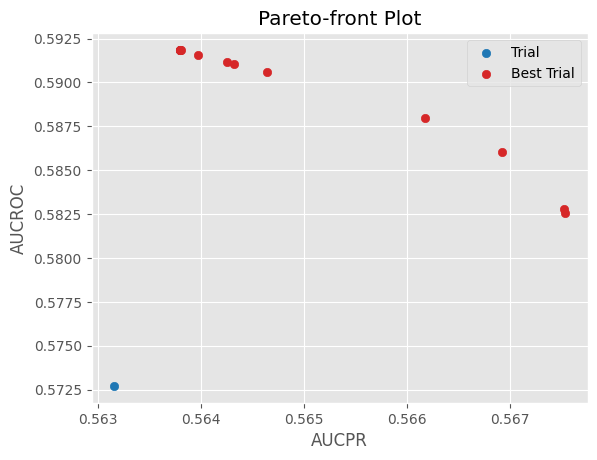

In [12]:
optuna.visualization.matplotlib.plot_pareto_front(study, target_names=["AUCPR", "AUCROC"])


In [ ]:

trials = study.best_trials

print(f"Number of trials on the Pareto front: {len(study.best_trials)}")

trial_with_highest_accuracy = max(study.best_trials, key=lambda t: t.values[1])
print(f"Trial with highest accuracy: ")
print(f"\tnumber: {trial_with_highest_accuracy.number}")
print(f"\tparams: {trial_with_highest_accuracy.params}")
print(f"\tvalues: {trial_with_highest_accuracy.values}")

print('Mean Score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [ ]:
trials

In [ ]:
study.trials_dataframe()

In [ ]:
rf_objective = create_cv_objective(X_train=X_train, y_train=y_train, cv=5, clf_callback=rf_callback, result_tracker_callback=tracker_callback_fn)


# generate study name based on model, fold and some random word?
study = optuna.create_study(direction='maximize', study_name=f"{get_random_string(8)}-rf")
study.optimize(rf_objective, n_trials = 3)

trial = study.best_trial

print('Mean Score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [ ]:
study.trials_dataframe()